<a href="https://colab.research.google.com/github/Marrmotta/dissertation/blob/Experiment-1A/Experiment_1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1A

## Data Import and Preprocessing

In [ ]:
# Install necessary libraries
!pip install gspread google-auth google-auth-oauthlib google-auth-httplib2

# Import libraries
import gspread
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

# Upload credentials file
from google.colab import files
uploaded = files.upload()  # Select the 'credentials.json' file you downloaded

In [ ]:
# Check the uploaded file name
credentials_filename = list(uploaded.keys())[0]

# Define the scopes
SCOPE = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

# Load credentials from the uploaded file
creds = Credentials.from_service_account_file(credentials_filename, scopes=SCOPE)

# Authorize and create the client
gc = gspread.authorize(creds)

In [ ]:
# Create helper functions
# Define the function to calculate Hedge's g
def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    g = (mean1 - mean2) / pooled_sd
    correction_factor = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g_value = g * correction_factor
    return hedges_g_value

# Define the function to categorize responses
def categorize_response(response):
    if response == -99:
        return 'Blank'
    elif response == 0:
        return 'Wrong'
    elif response == 1:
        return 'Correct'
    elif response == 2:
        return 'Misinformed'
    else:
        return None

# Function to process participant data
def process_participant_data(participant_row, counterbalance_df, gk_items):
    result = {
        'Total Blank': 0,
        'Total Wrong': 0,
        'Total Correct': 0,
        'Total Misinformed': 0,
        'Accurate Blank': 0,
        'Accurate Wrong': 0,
        'Accurate Correct': 0,
        'Accurate Misinformed': 0,
        'Neutral Blank': 0,
        'Neutral Wrong': 0,
        'Neutral Correct': 0,
        'Neutral Misinformed': 0,
        'Misleading Blank': 0,
        'Misleading Wrong': 0,
        'Misleading Correct': 0,
        'Misleading Misinformed': 0,
        'Easy Blank': 0,
        'Easy Wrong': 0,
        'Easy Correct': 0,
        'Easy Misinformed': 0,
        'Hard Blank': 0,
        'Hard Wrong': 0,
        'Hard Correct': 0,
        'Hard Misinformed': 0
    }

    for gk_num in gk_items:
        row = counterbalance_df[counterbalance_df['GK'] == gk_num].iloc[0]
        difficulty = row['Difficulty']
        experiment = 'E1'
        version = participant_row['Version']
        version_map = {'A': 'A', 'B': 'B', 'C': 'C'}
        frame_col = f'{experiment}{version_map[version]}'
        frame = row[frame_col]
        response_col = f'GK{gk_num}_coded'
        response = participant_row[response_col]

        category = categorize_response(response)
        if category is None:
            continue

        result[f'Total {category}'] += 1

        if frame == 1:
            frame_type = 'Accurate'
        elif frame == 2:
            frame_type = 'Neutral'
        elif frame == 3:
            frame_type = 'Misleading'
        else:
            continue

        result[f'{frame_type} {category}'] += 1

        if difficulty == 0:
            result[f'Easy {category}'] += 1
        elif difficulty == 1:
            result[f'Hard {category}'] += 1

    return result

# Create a function to get the fact framing based on the version and item
def get_fact_framing(version, item):
    version_column = f'E1{version}'
    item_index = counterbalance_data['GK'].index(int(item.split('_')[0][2:]))
    framing_code = counterbalance_data[version_column][item_index]
    return 'Accurate' if framing_code == 1 else ('Neutral' if framing_code == 2 else 'Misleading')

In [ ]:
# Load & Process Exp 1A Data
# Open the Google Sheet by name
spreadsheet_name = 'Dissertation Data R to Py'
sheet_name = 'Experiment 1A GK Only'
sheet = gc.open(spreadsheet_name).worksheet(sheet_name)

# Get the data as a list of lists
data = sheet.get_all_values()

# Convert data to DataFrame
gk_data_exp_1A = pd.DataFrame(data[1:], columns=data[0])
print("Data from Google Sheets:")
print(gk_data_exp_1A.head())

In [ ]:
# Check the data types of the columns
print("Data types before conversion:")
print(gk_data_exp_1A.dtypes)

# Convert columns to appropriate types if necessary
for column in gk_data_exp_1A.columns:
    if '_coded' in column:
        gk_data_exp_1A[column] = gk_data_exp_1A[column].astype(int)

# Verifying types after conversion
print("Data types after conversion:")
print(gk_data_exp_1A.dtypes)

In [ ]:
# Set the counterbalancing guide
counterbalance_data = {
    'GK': list(range(1, 61)),  # GK items 1 to 60
    'Difficulty': [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    'E1A': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    'E1B': [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    'E1C': [2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
}

# Ensure the columns include the individual item responses
gk_item_columns = [f'GK{i}_coded' for i in range(1, 37)]
relevant_columns = ['ID', 'Progress', 'Duration_sec', 'Presentation', 'Version'] + gk_item_columns

# Select relevant columns
filtered_df = gk_data_exp_1A[relevant_columns]

# Convert relevant columns to appropriate types
filtered_df['Presentation'] = filtered_df['Presentation'].astype(int)  # Convert to integer first

# Map the presentation types
presentation_mapping = {0: 'Scrolling Feed', 1: 'Page-based'}
filtered_df['Presentation'] = filtered_df['Presentation'].map(presentation_mapping)
filtered_df['Presentation'] = filtered_df['Presentation'].astype('category')  # Then convert to category

filtered_df['Version'] = filtered_df['Version'].astype('category')

# Ensure Duration_sec is numeric
filtered_df['Duration_sec'] = pd.to_numeric(filtered_df['Duration_sec'], errors='coerce')

# Convert wide DataFrame to long format
long_df = pd.melt(filtered_df, id_vars=['ID', 'Presentation', 'Version', 'Duration_sec'],
                  value_vars=gk_item_columns,
                  var_name='Item', value_name='Response')

# Add the difficulty and fact framing information based on the item number and version
gk_items_difficulty = {f'GK{i}_coded': 'Easy' if difficulty == 0 else 'Hard' for i, difficulty in enumerate(counterbalance_data['Difficulty'], 1)}

long_df['Difficulty'] = long_df['Item'].map(gk_items_difficulty)
long_df['Fact_Framing'] = long_df.apply(lambda row: get_fact_framing(row['Version'], row['Item']), axis=1)

# Ensure Response is numeric
long_df['Response'] = long_df['Response'].astype(int)

# Add a new column for Decoded_Response
response_mapping = {
    -99: 'Blank',
    0: 'Wrong',
    1: 'Correct',
    2: 'Misinformed'
}

long_df['Decoded_Response'] = long_df['Response'].map(response_mapping)

In [ ]:
# Prepare the data for logistic regression for each response type (Correct, Misinformed)
# Binary coding for mixed effects analysis
long_df['Correct_Binary'] = long_df['Response'].apply(lambda x: 1 if x == 1 else 0)
long_df['Misinformed_Binary'] = long_df['Response'].apply(lambda x: 1 if x == 2 else 0)

In [ ]:
# Prepare the data for the propotion ANCOVA for each response type (Correct, Misinformed)
# Calculate the total number of items per participant
total_items_per_participant = long_df.groupby('ID')['Item'].count().reset_index()
total_items_per_participant.columns = ['ID', 'Total_Items']

# Calculate the counts of each Decoded_Response type per participant
response_counts = long_df.groupby(['ID', 'Decoded_Response']).size().unstack(fill_value=0).reset_index()

# Merge total items with response counts
response_proportions = pd.merge(response_counts, total_items_per_participant, on='ID')

# Calculate proportions
for response_type in ['Blank', 'Correct', 'Misinformed', 'Wrong']:
    response_proportions[response_type] = response_proportions[response_type] / response_proportions['Total_Items']

# Merge the proportions back into the long_df to align with the rest of the data
long_df = pd.merge(long_df, response_proportions, on='ID', suffixes=('', '_Proportion'))

# Add Difficulty and Fact_Framing to proportions_df
proportions_df = long_df[['ID', 'Presentation', 'Duration_sec', 'Correct', 'Misinformed']].drop_duplicates()

# Merge Difficulty and Fact_Framing information into proportions_df
difficulty_fact_framing_df = long_df[['ID', 'Difficulty', 'Fact_Framing']].drop_duplicates()
proportions_df = pd.merge(proportions_df, difficulty_fact_framing_df, on='ID')

# Convert to categorical type
proportions_df['Presentation'] = proportions_df['Presentation'].astype('category')
proportions_df['Difficulty'] = proportions_df['Difficulty'].astype('category')
proportions_df['Fact_Framing'] = proportions_df['Fact_Framing'].astype('category')

# Display the prepared DataFrame
print(long_df.head())

# Save this DataFrame for future reference
long_df.to_csv('processed_long_df.csv', index=False)

Saving credentials.json to credentials.json
Data from Google Sheets:
  ID Progress Duration_sec Presentation Version GK1_coded GK2_coded GK3_coded  \
0  1      100         1244            0       C       -99         1       -99   
1  2      100         2053            1       C       -99       -99       -99   
2  3      100         2171            0       B       -99       -99       -99   
3  4      100         1587            0       C         1         2       -99   
4  5      100         2905            0       A         1         1         0   

  GK4_coded GK5_coded  ... GK27_coded GK28_coded GK29_coded GK30_coded  \
0         1         1  ...          1        -99          1          1   
1       -99         1  ...          1        -99        -99          1   
2         1         1  ...          1        -99          1          1   
3         1         1  ...          1          2        -99          1   
4         1         1  ...          0          0          1          1   


## Mixed Effects Logistic Regression

In [ ]:
# Ensure categorical variables are properly encoded
long_df['Presentation'] = long_df['Presentation'].astype('category')
long_df['Difficulty'] = long_df['Difficulty'].astype('category')
long_df['Fact_Framing'] = long_df['Fact_Framing'].astype('category')

### Correct Responses


In [ ]:
# Mixed-Effect Logistic Regression for Correct Responses
model_correct = smf.mixedlm("Correct_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                            long_df,
                            groups=long_df["ID"],
                            re_formula="~1")
result_correct = model_correct.fit()
print(result_correct.summary())

                                         Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     Correct_Binary
No. Observations:                     7200                        Method:                                 REML          
No. Groups:                           200                         Scale:                                  0.1618        
Min. group size:                      36                          Log-Likelihood:                         -3957.3205    
Max. group size:                      36                          Converged:                              Yes           
Mean group size:                      36.0                                                                              
------------------------------------------------------------------------------------------------------------------------
                                                                          

In [ ]:
# Post Hoc for Correct Responses
# Convert columns to strings explicitly
presentation_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
difficulty_fact_framing = long_df['Difficulty'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
presentation_difficulty_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Difficulty'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)

# Perform post-hoc analyses for the significant interaction between Presentation and Fact Framing
posthoc = mc.MultiComparison(long_df['Correct_Binary'], presentation_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation and Fact Framing (Correct):")
print(posthoc_results)

# Perform post-hoc analyses for the significant interaction between Difficulty and Fact Framing
posthoc = mc.MultiComparison(long_df['Correct_Binary'], difficulty_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Difficulty and Fact Framing (Correct):")
print(posthoc_results)

# Perform post-hoc analyses for the significant three-way interaction between Presentation, Difficulty, and Fact Framing
posthoc = mc.MultiComparison(long_df['Correct_Binary'], presentation_difficulty_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation, Difficulty, and Fact Framing (Correct):")
print(posthoc_results)


Post-hoc results for Presentation and Fact Framing (Correct):
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
      Page-based:Accurate     Page-based:Misleading  -0.0726  0.004 -0.1298 -0.0154   True
      Page-based:Accurate        Page-based:Neutral   -0.085 0.0003 -0.1422 -0.0278   True
      Page-based:Accurate   Scrolling Feed:Accurate  -0.0527 0.0938 -0.1102  0.0048  False
      Page-based:Accurate Scrolling Feed:Misleading   -0.131    0.0 -0.1885 -0.0735   True
      Page-based:Accurate    Scrolling Feed:Neutral  -0.0889 0.0002 -0.1464 -0.0314   True
    Page-based:Misleading        Page-based:Neutral  -0.0124 0.9898 -0.0696  0.0448  False
    Page-based:Misleading   Scrolling Feed:Accurate   0.0199 0.9225 -0.0376  0.0774  False
    Page-based:Misleading Sc

### Misinformed Responses

In [ ]:
# Mixed-Effect Logistic Regression for Misinformed Responses
model_misinformed = smf.mixedlm("Misinformed_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                long_df,
                                groups=long_df["ID"],
                                re_formula="~1")
result_misinformed = model_misinformed.fit()
print(result_misinformed.summary())

                                         Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   Misinformed_Binary
No. Observations:                    7200                      Method:                               REML              
No. Groups:                          200                       Scale:                                0.0420            
Min. group size:                     36                        Log-Likelihood:                       1040.0911         
Max. group size:                     36                        Converged:                            Yes               
Mean group size:                     36.0                                                                              
-----------------------------------------------------------------------------------------------------------------------
                                                                             Coef

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# Post Hoc for Misinformed Responses
# Perform post-hoc analyses for the significant interaction between Presentation and Fact Framing
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], presentation_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation and Fact Framing (Misinformed):")
print(posthoc_results)

# Perform post-hoc analyses for the significant interaction between Difficulty and Fact Framing
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], difficulty_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Difficulty and Fact Framing (Misinformed):")
print(posthoc_results)

# Perform post-hoc analyses for the significant three-way interaction between Presentation, Difficulty, and Fact Framing
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], presentation_difficulty_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation, Difficulty, and Fact Framing (Misinformed):")
print(posthoc_results)


Post-hoc results for Presentation and Fact Framing (Misinformed):
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
      Page-based:Accurate     Page-based:Misleading   0.0751    0.0  0.0507  0.0995   True
      Page-based:Accurate        Page-based:Neutral   0.0173 0.3276 -0.0071  0.0417  False
      Page-based:Accurate   Scrolling Feed:Accurate    0.007 0.9646 -0.0175  0.0315  False
      Page-based:Accurate Scrolling Feed:Misleading   0.0828    0.0  0.0583  0.1073   True
      Page-based:Accurate    Scrolling Feed:Neutral   0.0196 0.2002 -0.0049  0.0441  False
    Page-based:Misleading        Page-based:Neutral  -0.0578    0.0 -0.0821 -0.0334   True
    Page-based:Misleading   Scrolling Feed:Accurate  -0.0681    0.0 -0.0926 -0.0436   True
    Page-based:Misleadin

## Proportion Based ANCOVA

In [ ]:
# ANCOVA for Correct Responses
model_formula_correct = 'Correct ~ Presentation * Difficulty * Fact_Framing + Duration_sec'
model_correct_ancova = ols(model_formula_correct, data=proportions_df).fit()
ancova_correct = sm.stats.anova_lm(model_correct_ancova, typ=2)
print("ANCOVA Results for Correct Proportion:")
print(ancova_correct)
print(model_correct_ancova.summary())

ANCOVA Results for Correct Proportion:
                                            sum_sq      df             F  \
Presentation                          3.263592e-01     1.0  5.444354e+00   
Difficulty                            9.677655e-30     1.0  1.614435e-28   
Fact_Framing                          7.902881e-30     2.0  6.591829e-29   
Presentation:Difficulty               1.932969e-29     1.0  3.224596e-28   
Presentation:Fact_Framing             5.773441e-29     2.0  4.815653e-28   
Difficulty:Fact_Framing               1.240819e-29     2.0  1.034973e-28   
Presentation:Difficulty:Fact_Framing  4.817553e-30     2.0  4.018342e-29   
Duration_sec                          4.755920e+00     1.0  7.933868e+01   
Residual                              7.115416e+01  1187.0           NaN   

                                            PR(>F)  
Presentation                          1.979799e-02  
Difficulty                            1.000000e+00  
Fact_Framing                          1.0

In [ ]:
# Post Hoc for Correct Responses
mc_correct = mc.MultiComparison(proportions_df['Correct'], proportions_df['Presentation'].astype(str) + ':' + proportions_df['Difficulty'].astype(str) + ':' + proportions_df['Fact_Framing'].astype(str))
posthoc_correct_results = mc_correct.tukeyhsd()
print("Post-hoc results for Correct Responses:")
print(posthoc_correct_results)


Post-hoc results for Correct Responses:
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
            group1                         group2             meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------------------------
      Page-based:Easy:Accurate     Page-based:Easy:Misleading      0.0    1.0 -0.1165 0.1165  False
      Page-based:Easy:Accurate        Page-based:Easy:Neutral      0.0    1.0 -0.1165 0.1165  False
      Page-based:Easy:Accurate       Page-based:Hard:Accurate      0.0    1.0 -0.1165 0.1165  False
      Page-based:Easy:Accurate     Page-based:Hard:Misleading      0.0    1.0 -0.1165 0.1165  False
      Page-based:Easy:Accurate        Page-based:Hard:Neutral      0.0    1.0 -0.1165 0.1165  False
      Page-based:Easy:Accurate   Scrolling Feed:Easy:Accurate  -0.0384 0.9957 -0.1554 0.0787  False
      Page-based:Easy:Accurate Scrolling Feed:Easy:Misleadin

In [ ]:
# ANCOVA for Misinformed Responses
model_formula_misinformed = 'Misinformed ~ Presentation * Difficulty * Fact_Framing + Duration_sec'
model_misinformed_ancova = ols(model_formula_misinformed, data=proportions_df).fit()
ancova_misinformed = sm.stats.anova_lm(model_misinformed_ancova, typ=2)
print("ANCOVA Results for Misinformed Proportion:")
print(ancova_misinformed)
print(model_misinformed_ancova.summary())

ANCOVA Results for Misinformed Proportion:
                                            sum_sq      df             F  \
Presentation                          6.402810e-03     1.0  1.915997e+00   
Difficulty                            3.241904e-31     1.0  9.701177e-29   
Fact_Framing                          1.858500e-31     2.0  2.780717e-29   
Presentation:Difficulty               2.256723e-32     1.0  6.753090e-30   
Presentation:Fact_Framing             2.934242e-31     2.0  4.390259e-29   
Difficulty:Fact_Framing               6.977793e-32     2.0  1.044028e-29   
Presentation:Difficulty:Fact_Framing  5.867481e-33     2.0  8.779018e-31   
Duration_sec                          1.845662e-01     1.0  5.523018e+01   
Residual                              3.966674e+00  1187.0           NaN   

                                            PR(>F)  
Presentation                          1.665588e-01  
Difficulty                            1.000000e+00  
Fact_Framing                         

In [ ]:
# Post Hoc for Misinformed Responses
mc_misinformed = mc.MultiComparison(proportions_df['Misinformed'], proportions_df['Presentation'].astype(str) + ':' + proportions_df['Difficulty'].astype(str) + ':' + proportions_df['Fact_Framing'].astype(str))
posthoc_misinformed_results = mc_misinformed.tukeyhsd()
print("Post-hoc results for Misinformed Responses:")
print(posthoc_misinformed_results)

Post-hoc results for Misinformed Responses:
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
            group1                         group2             meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------------------------
      Page-based:Easy:Accurate     Page-based:Easy:Misleading      0.0    1.0 -0.0272 0.0272  False
      Page-based:Easy:Accurate        Page-based:Easy:Neutral      0.0    1.0 -0.0272 0.0272  False
      Page-based:Easy:Accurate       Page-based:Hard:Accurate      0.0    1.0 -0.0272 0.0272  False
      Page-based:Easy:Accurate     Page-based:Hard:Misleading      0.0    1.0 -0.0272 0.0272  False
      Page-based:Easy:Accurate        Page-based:Hard:Neutral      0.0    1.0 -0.0272 0.0272  False
      Page-based:Easy:Accurate   Scrolling Feed:Easy:Accurate   0.0057 0.9999 -0.0217 0.0331  False
      Page-based:Easy:Accurate Scrolling Feed:Easy:Misle

## ANCOVA Diagnostics

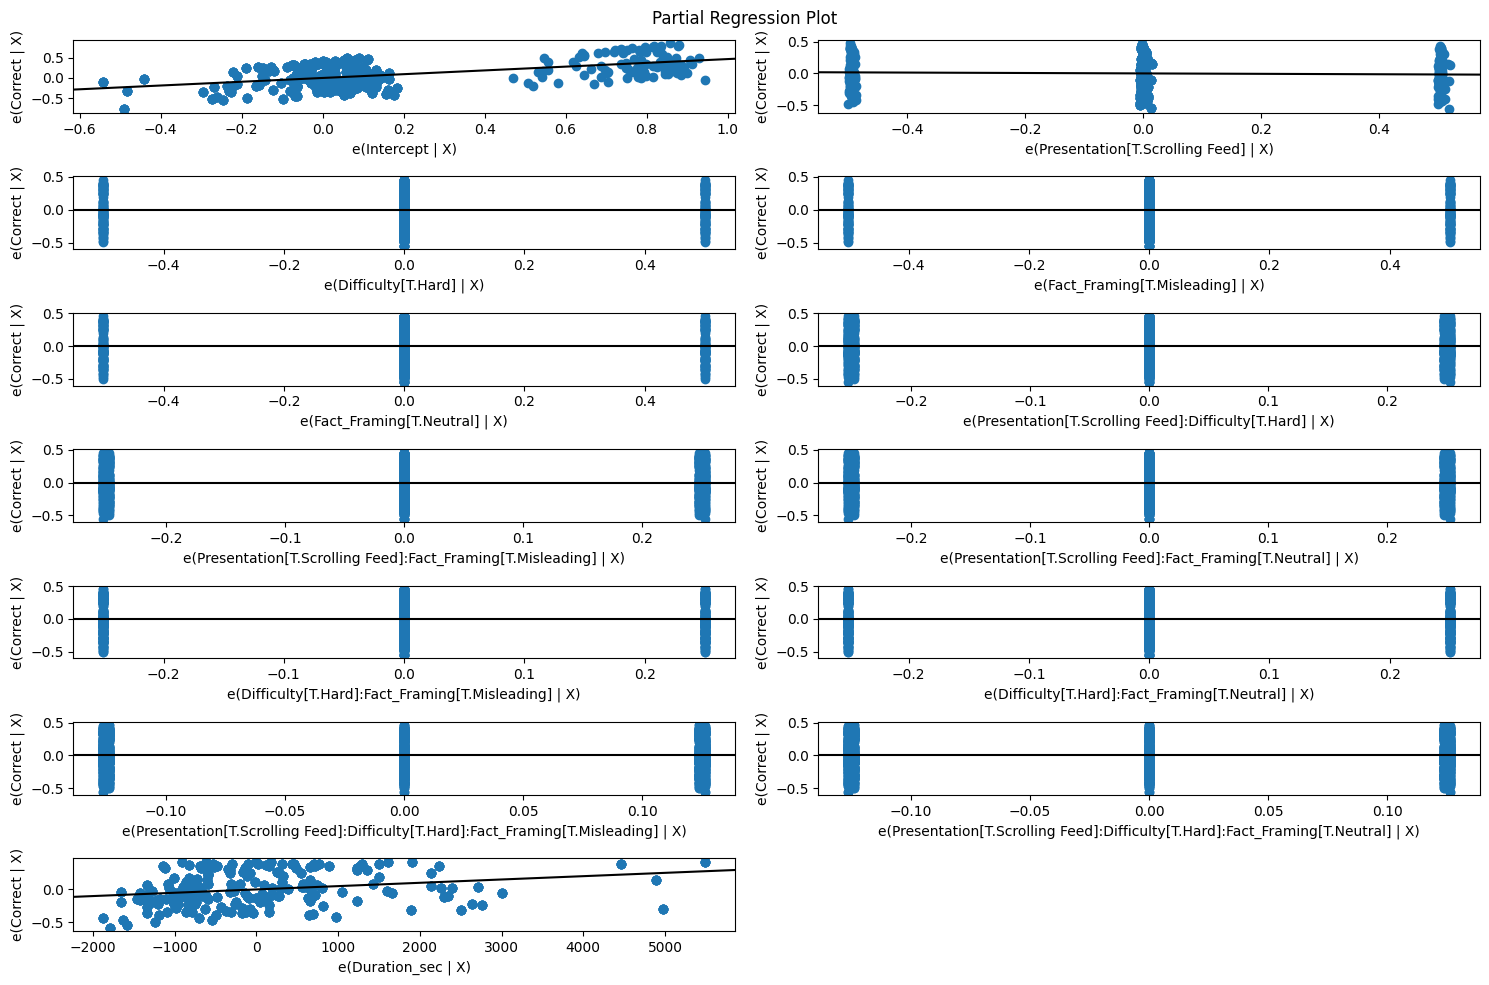

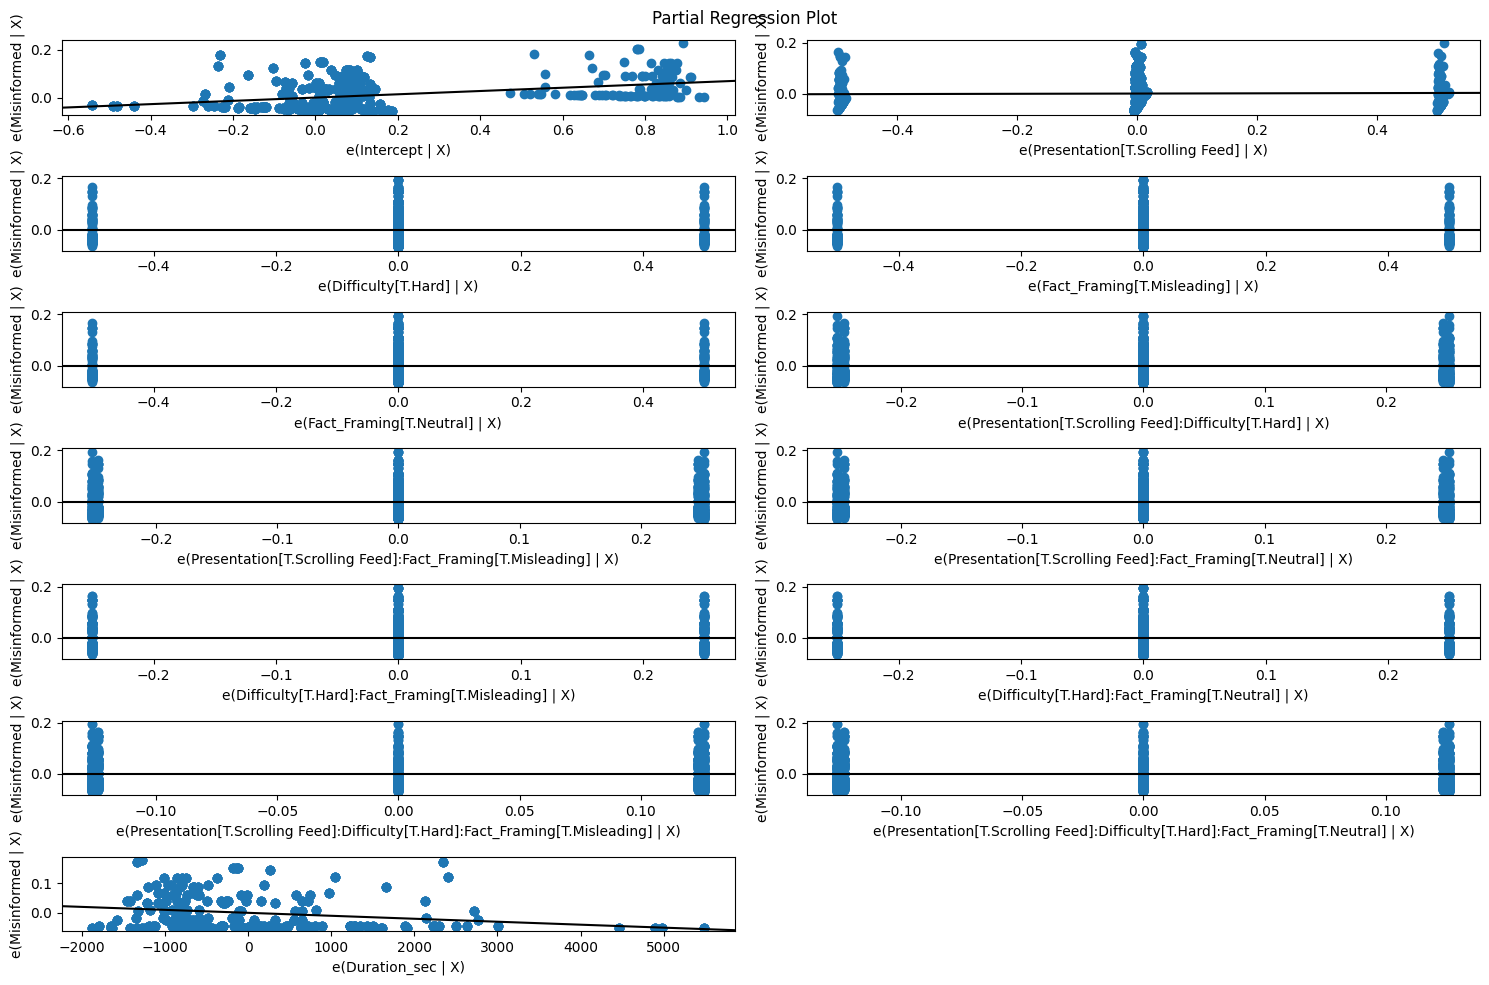

Breusch-Pagan test p-value for Correct model: 0.08827586652018901
Breusch-Pagan test p-value for Misinformed model: 0.9682627357659667


In [ ]:
# Plot diagnostics for the ANCOVA model for correct responses
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_correct_ancova, fig=fig)
plt.show()

# Plot diagnostics for the ANCOVA model for misinformed responses
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_misinformed_ancova, fig=fig)
plt.show()

# Check for homoscedasticity using Breusch-Pagan test
_, pval_correct, __, f_pval_correct = sm.stats.diagnostic.het_breuschpagan(model_correct_ancova.resid, model_correct_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Correct model: {pval_correct}")

_, pval_misinformed, __, f_pval_misinformed = sm.stats.diagnostic.het_breuschpagan(model_misinformed_ancova.resid, model_misinformed_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Misinformed model: {pval_misinformed}")

## Raw Count Analyses

In [ ]:
# Mixed-Effect Logistic Regression for Correct Responses (Raw Counts)
model_correct_raw = smf.mixedlm("Correct_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                long_df,
                                groups=long_df["ID"],
                                re_formula="~1")
result_correct_raw = model_correct_raw.fit()
print("Mixed Effects Results for Correct Responses (Raw Counts):")
print(result_correct_raw.summary())

# Mixed-Effect Logistic Regression for Misinformed Responses (Raw Counts)
model_misinformed_raw = smf.mixedlm("Misinformed_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                    long_df,
                                    groups=long_df["ID"],
                                    re_formula="~1")
result_misinformed_raw = model_misinformed_raw.fit()
print("Mixed Effects Results for Misinformed Responses (Raw Counts):")
print(result_misinformed_raw.summary())


Mixed Effects Results for Correct Responses (Raw Counts):
                                         Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     Correct_Binary
No. Observations:                     7200                        Method:                                 REML          
No. Groups:                           200                         Scale:                                  0.1618        
Min. group size:                      36                          Log-Likelihood:                         -3957.3205    
Max. group size:                      36                          Converged:                              Yes           
Mean group size:                      36.0                                                                              
------------------------------------------------------------------------------------------------------------------------
                

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mixed Effects Results for Misinformed Responses (Raw Counts):
                                         Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   Misinformed_Binary
No. Observations:                    7200                      Method:                               REML              
No. Groups:                          200                       Scale:                                0.0420            
Min. group size:                     36                        Log-Likelihood:                       1040.0911         
Max. group size:                     36                        Converged:                            Yes               
Mean group size:                     36.0                                                                              
-----------------------------------------------------------------------------------------------------------------------
                   

In [ ]:
# ANCOVA for Correct Responses (Raw Counts)
model_formula_correct_raw = 'Correct ~ Presentation * Difficulty * Fact_Framing + Duration_sec'
model_correct_raw_ancova = ols(model_formula_correct_raw, data=long_df).fit()
ancova_correct_raw = sm.stats.anova_lm(model_correct_raw_ancova, typ=2)
print("ANCOVA Results for Correct Raw Count:")
print(ancova_correct_raw)
print(model_correct_raw_ancova.summary())

# Post Hoc for Correct Responses (Raw Counts)
mc_correct_raw = mc.MultiComparison(long_df['Correct_Binary'], long_df['Presentation'].astype(str) + ':' + long_df['Difficulty'].astype(str) + ':' + long_df['Fact_Framing'].astype(str))
posthoc_correct_raw_results = mc_correct_raw.tukeyhsd()
print("Post-hoc results for Correct Raw Counts:")
print(posthoc_correct_raw_results)

# ANCOVA for Misinformed Responses (Raw Counts)
model_formula_misinformed_raw = 'Misinformed ~ Presentation * Difficulty * Fact_Framing + Duration_sec'
model_misinformed_raw_ancova = ols(model_formula_misinformed_raw, data=long_df).fit()
ancova_misinformed_raw = sm.stats.anova_lm(model_misinformed_raw_ancova, typ=2)
print("ANCOVA Results for Misinformed Raw Count:")
print(ancova_misinformed_raw)
print(model_misinformed_raw_ancova.summary())

# Post Hoc for Misinformed Responses (Raw Counts)
mc_misinformed_raw = mc.MultiComparison(long_df['Misinformed_Binary'], long_df['Presentation'].astype(str) + ':' + long_df['Difficulty'].astype(str) + ':' + long_df['Fact_Framing'].astype(str))
posthoc_misinformed_raw_results = mc_misinformed_raw.tukeyhsd()
print("Post-hoc results for Misinformed Raw Counts:")
print(posthoc_misinformed_raw_results)


ANCOVA Results for Correct Raw Count:
                                            sum_sq      df             F  \
Presentation                          1.957418e+00     1.0  3.295947e+01   
Difficulty                            8.307199e-28     1.0  1.398786e-26   
Fact_Framing                          4.471500e-29     2.0  3.764609e-28   
Presentation:Difficulty               1.778381e-10     1.0  2.994480e-09   
Presentation:Fact_Framing             5.773865e-06     2.0  4.861087e-05   
Difficulty:Fact_Framing               6.213751e-02     2.0  5.231432e-01   
Presentation:Difficulty:Fact_Framing  3.672359e-02     2.0  3.091803e-01   
Duration_sec                          2.846371e+01     1.0  4.792788e+02   
Residual                              4.268261e+02  7187.0           NaN   

                                             PR(>F)  
Presentation                           9.793395e-09  
Difficulty                             1.000000e+00  
Fact_Framing                           

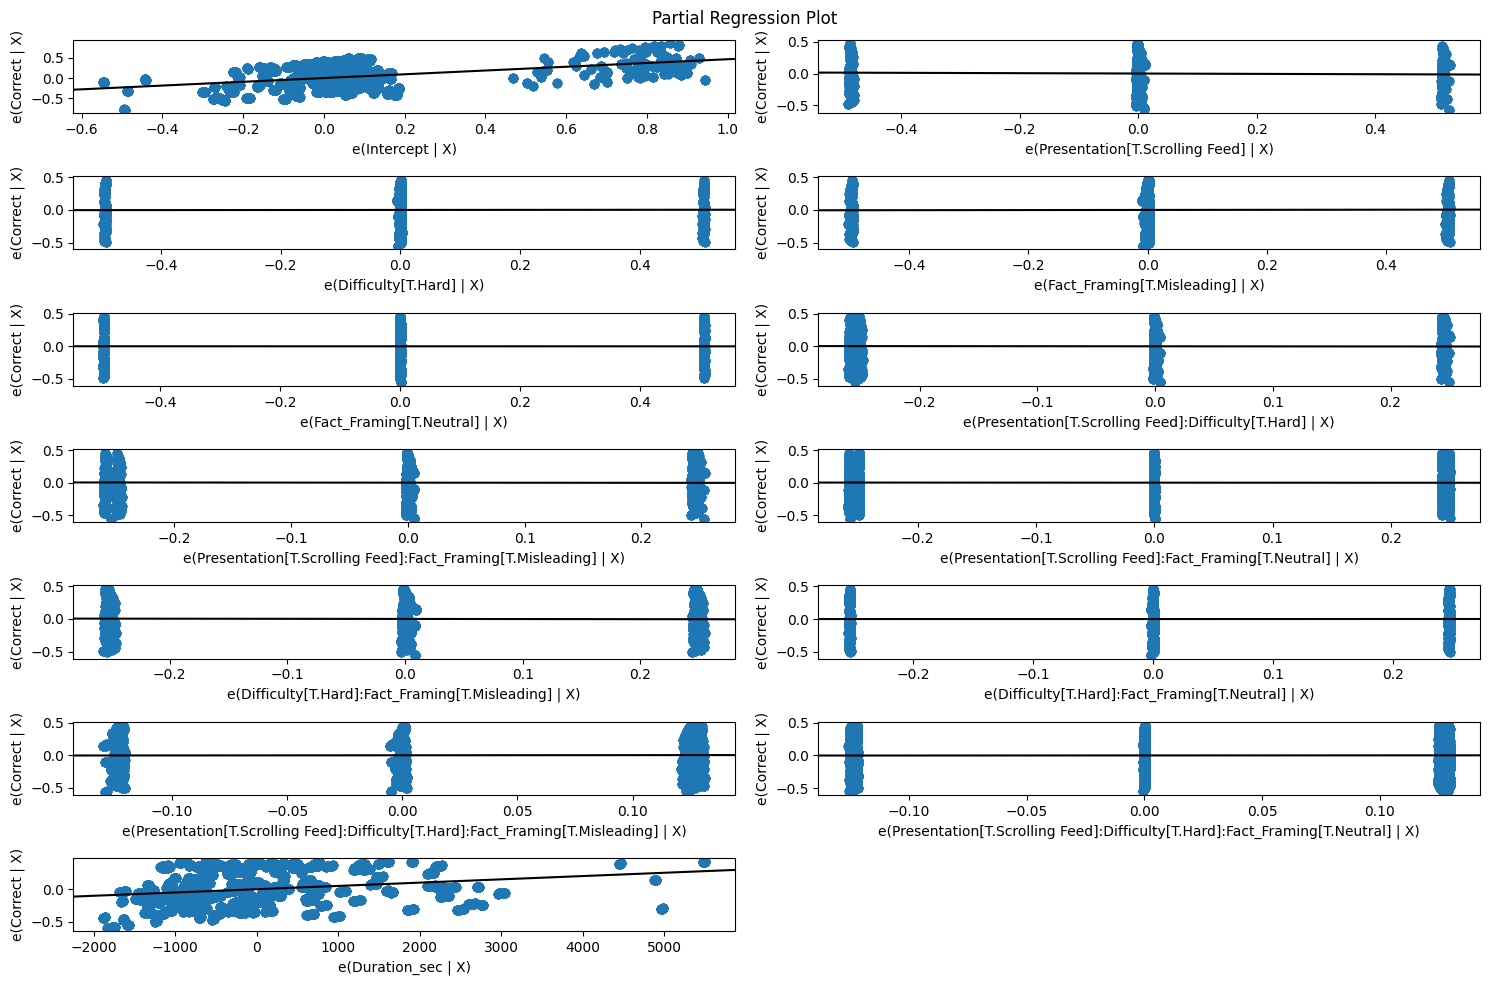

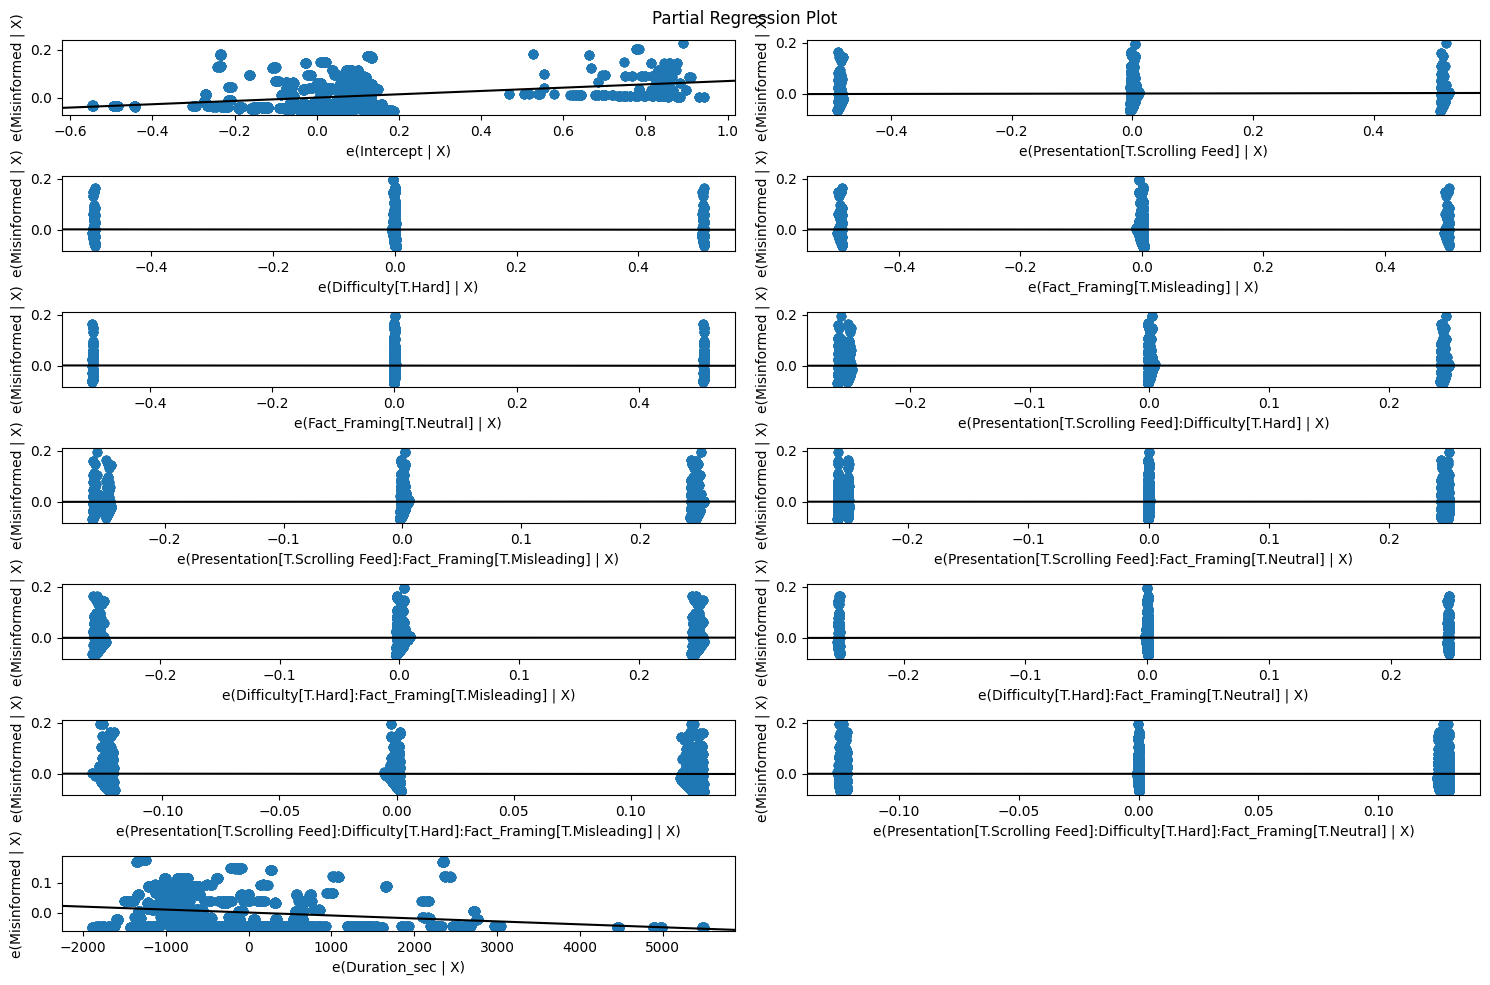

Breusch-Pagan test p-value for Correct model (Raw Counts): 7.704664514092704e-20
Breusch-Pagan test p-value for Misinformed model (Raw Counts): 0.0020166219655335504


In [ ]:
# Plot diagnostics for the ANCOVA model for correct responses (Raw Counts)
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_correct_raw_ancova, fig=fig)
plt.show()

# Plot diagnostics for the ANCOVA model for misinformed responses (Raw Counts)
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_misinformed_raw_ancova, fig=fig)
plt.show()

# Check for homoscedasticity using Breusch-Pagan test (Raw Counts)
_, pval_correct_raw, __, f_pval_correct_raw = sm.stats.diagnostic.het_breuschpagan(model_correct_raw_ancova.resid, model_correct_raw_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Correct model (Raw Counts): {pval_correct_raw}")

_, pval_misinformed_raw, __, f_pval_misinformed_raw = sm.stats.diagnostic.het_breuschpagan(model_misinformed_raw_ancova.resid, model_misinformed_raw_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Misinformed model (Raw Counts): {pval_misinformed_raw}")


## Effect Sizes

In [ ]:
# Define a function to calculate Hedge's g
def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    g = (mean1 - mean2) / pooled_sd
    correction_factor = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g_value = g * correction_factor
    return hedges_g_value

# Group by Presentation, Difficulty, and Fact Framing
grouped_lme = long_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing'])

# Calculate means, standard deviations, and sample sizes
means_lme = grouped_lme['Correct_Binary'].mean()
sds_lme = grouped_lme['Correct_Binary'].std()
ns_lme = grouped_lme['Correct_Binary'].count()

# Define pairs for Hedge's g calculation based on significant results
significant_pairs_lme = [
    ('Scrolling Feed', 'Easy', 'Accurate', 'Page-based', 'Easy', 'Accurate'),
    ('Scrolling Feed', 'Easy', 'Misleading', 'Page-based', 'Easy', 'Misleading'),
    ('Scrolling Feed', 'Easy', 'Accurate', 'Scrolling Feed', 'Hard', 'Accurate'),
    ('Page-based', 'Easy', 'Accurate', 'Page-based', 'Hard', 'Accurate'),
    ('Scrolling Feed', 'Easy', 'Misleading', 'Scrolling Feed', 'Hard', 'Misleading'),
    ('Page-based', 'Easy', 'Misleading', 'Page-based', 'Hard', 'Misleading'),
    ('Scrolling Feed', 'Easy', 'Accurate', 'Scrolling Feed', 'Easy', 'Misleading'),
    ('Page-based', 'Easy', 'Accurate', 'Page-based', 'Easy', 'Misleading'),
    ('Scrolling Feed', 'Hard', 'Accurate', 'Scrolling Feed', 'Hard', 'Misleading'),
    ('Page-based', 'Hard', 'Accurate', 'Page-based', 'Hard', 'Misleading')
]

# Calculate Hedge's g for each pair
hedges_g_values_lme = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_lme.loc[(p1, d1, f1)], means_lme.loc[(p2, d2, f2)]
    sd1, sd2 = sds_lme.loc[(p1, d1, f1)], sds_lme.loc[(p2, d2, f2)]
    n1, n2 = ns_lme.loc[(p1, d1, f1)], ns_lme.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_lme[((p1, d1, f1), (p2, d2, f2))] = g

# Print Hedge's g values
print("Hedge's g for Mixed Effects Model:")
for groups, g_value in hedges_g_values_lme.items():
    print(f"Hedge's g for {groups}: {g_value}")


Hedge's g for Mixed Effects Model:
Hedge's g for (('Scrolling Feed', 'Easy', 'Accurate'), ('Page-based', 'Easy', 'Accurate')): -0.032933050017030514
Hedge's g for (('Scrolling Feed', 'Easy', 'Misleading'), ('Page-based', 'Easy', 'Misleading')): -0.19917872486892885
Hedge's g for (('Scrolling Feed', 'Easy', 'Accurate'), ('Scrolling Feed', 'Hard', 'Accurate')): 0.6930668208222983
Hedge's g for (('Page-based', 'Easy', 'Accurate'), ('Page-based', 'Hard', 'Accurate')): 0.5551461678307106
Hedge's g for (('Scrolling Feed', 'Easy', 'Misleading'), ('Scrolling Feed', 'Hard', 'Misleading')): 0.550661459297859
Hedge's g for (('Page-based', 'Easy', 'Misleading'), ('Page-based', 'Hard', 'Misleading')): 0.7020947631629718
Hedge's g for (('Scrolling Feed', 'Easy', 'Accurate'), ('Scrolling Feed', 'Easy', 'Misleading')): 0.24679186964934394
Hedge's g for (('Page-based', 'Easy', 'Accurate'), ('Page-based', 'Easy', 'Misleading')): 0.08045537683200063
Hedge's g for (('Scrolling Feed', 'Hard', 'Accurate'), 

In [ ]:
# Group by Presentation, Difficulty, and Fact Framing
grouped_proportions = proportions_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing'])
grouped_raw = long_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing'])

# Calculate means, standard deviations, and sample sizes
means_proportions = grouped_proportions['Correct'].mean()
sds_proportions = grouped_proportions['Correct'].std()
ns_proportions = grouped_proportions['Correct'].count()

means_raw = grouped_raw['Correct_Binary'].mean()
sds_raw = grouped_raw['Correct_Binary'].std()
ns_raw = grouped_raw['Correct_Binary'].count()

# Calculate Hedge's g for Proportions
hedges_g_values_proportions = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_proportions.loc[(p1, d1, f1)], means_proportions.loc[(p2, d2, f2)]
    sd1, sd2 = sds_proportions.loc[(p1, d1, f1)], sds_proportions.loc[(p2, d2, f2)]
    n1, n2 = ns_proportions.loc[(p1, d1, f1)], ns_proportions.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_proportions[((p1, d1, f1), (p2, d2, f2))] = g

print("Hedge's g for Proportions:")
for groups, g_value in hedges_g_values_proportions.items():
    print(f"Hedge's g for {groups}: {g_value}")

# Calculate Hedge's g for Raw Counts
hedges_g_values_raw = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_raw.loc[(p1, d1, f1)], means_raw.loc[(p2, d2, f2)]
    sd1, sd2 = sds_raw.loc[(p1, d1, f1)], sds_raw.loc[(p2, d2, f2)]
    n1, n2 = ns_raw.loc[(p1, d1, f1)], ns_raw.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_raw[((p1, d1, f1), (p2, d2, f2))] = g

print("Hedge's g for Raw Counts:")
for groups, g_value in hedges_g_values_raw.items():
    print(f"Hedge's g for {groups}: {g_value}")


## All the Plots

In [ ]:
# Define a function to save the plots
def save_plot(fig, filename):
    fig.savefig(filename, bbox_inches='tight')

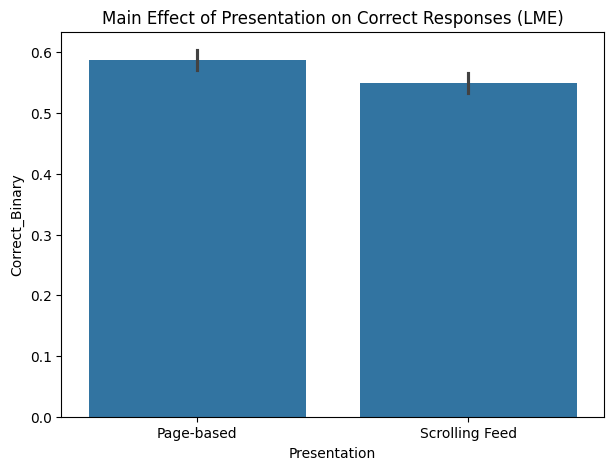

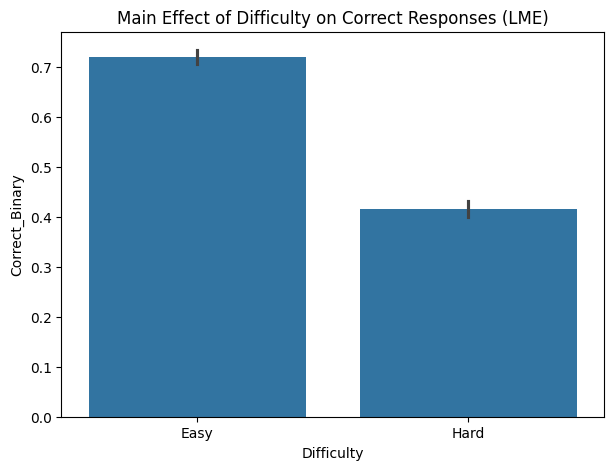

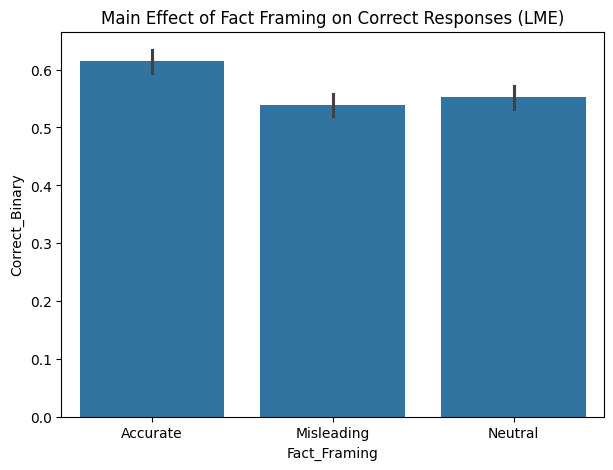

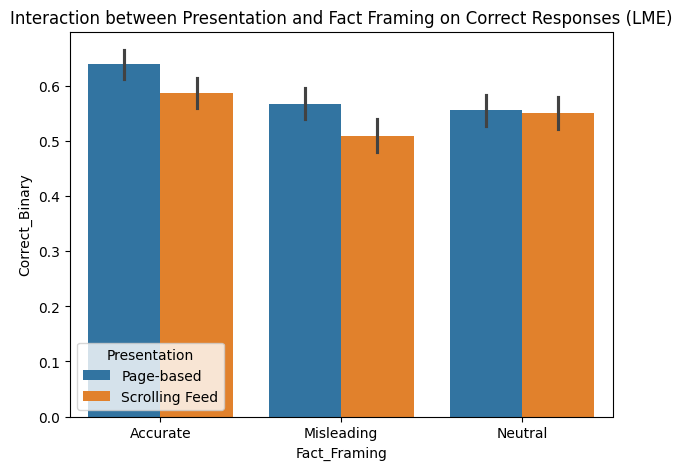

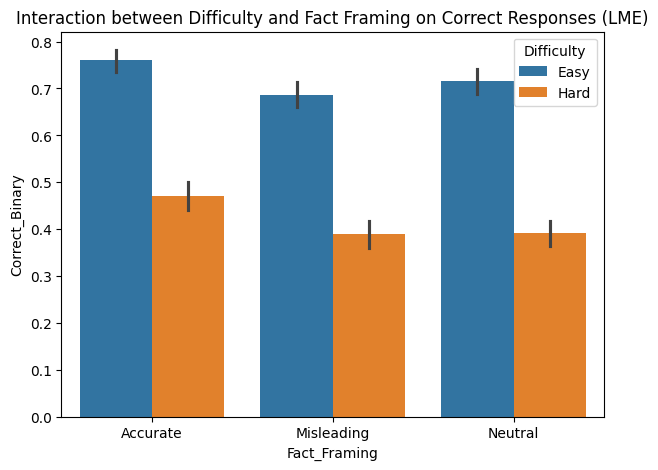

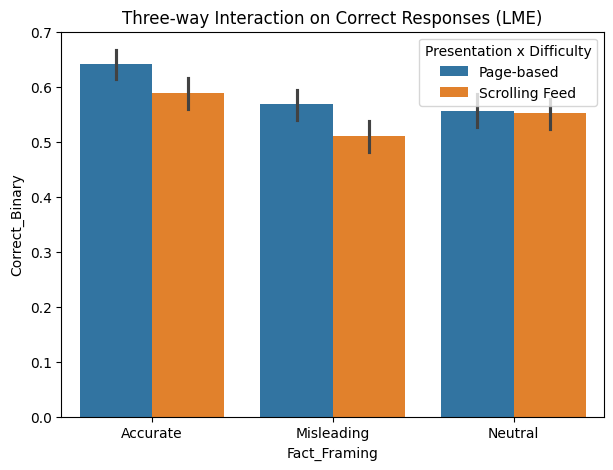

In [ ]:
# Plots for Mixed Effects Model
# Main effect of Presentation on Correct Responses
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Correct_Binary')
plt.title('Main Effect of Presentation on Correct Responses (LME)')
save_plot(fig1, 'main_effect_presentation_correct_lme.png')
plt.show()

# Main effect of Difficulty on Correct Responses
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Difficulty', y='Correct_Binary')
plt.title('Main Effect of Difficulty on Correct Responses (LME)')
save_plot(fig2, 'main_effect_difficulty_correct_lme.png')
plt.show()

# Main effect of Fact Framing on Correct Responses
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary')
plt.title('Main Effect of Fact Framing on Correct Responses (LME)')
save_plot(fig3, 'main_effect_fact_framing_correct_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Correct Responses
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Correct Responses (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_correct_lme.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Correct Responses
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Correct Responses (LME)')
save_plot(fig5, 'interaction_difficulty_fact_framing_correct_lme.png')
plt.show()

# Three-way interaction on Correct Responses
fig6 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Three-way Interaction on Correct Responses (LME)')
plt.legend(title='Presentation x Difficulty', loc='upper right')
save_plot(fig6, 'three_way_interaction_correct_lme.png')
plt.show()


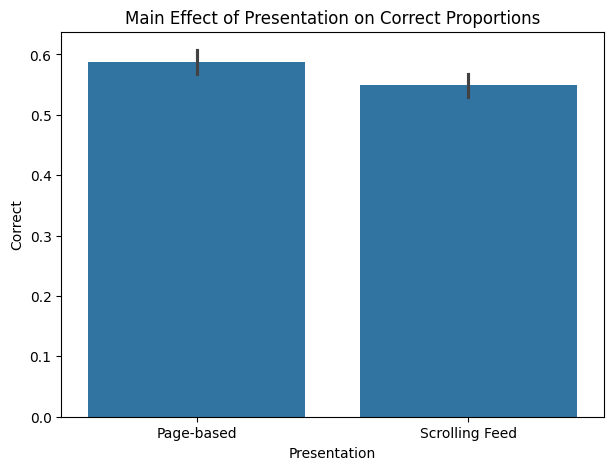

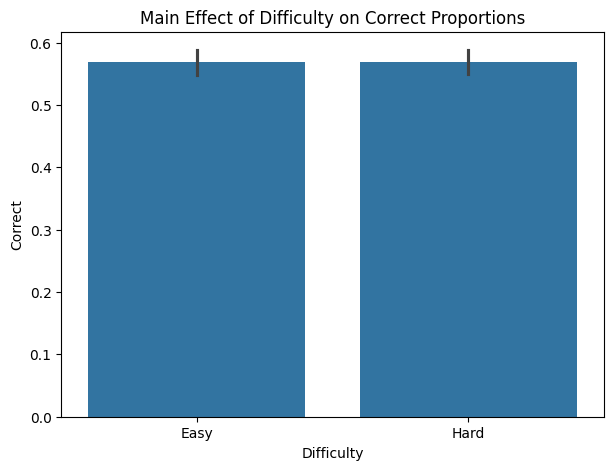

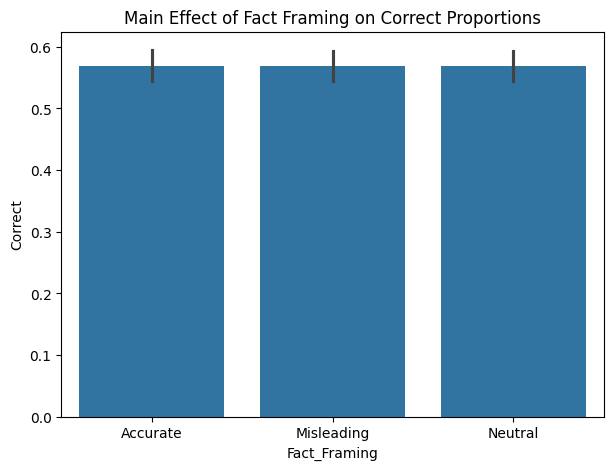

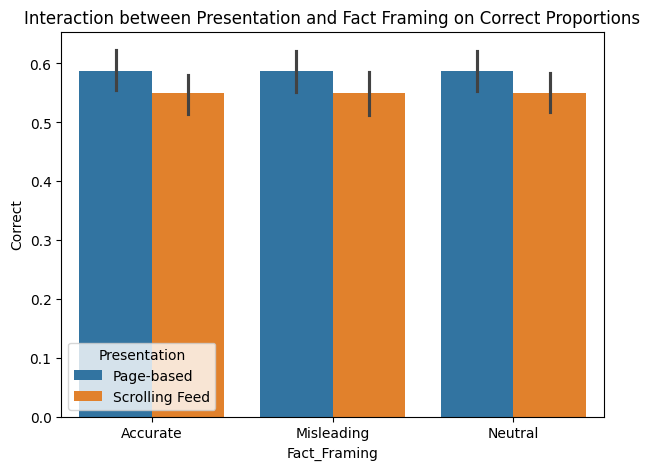

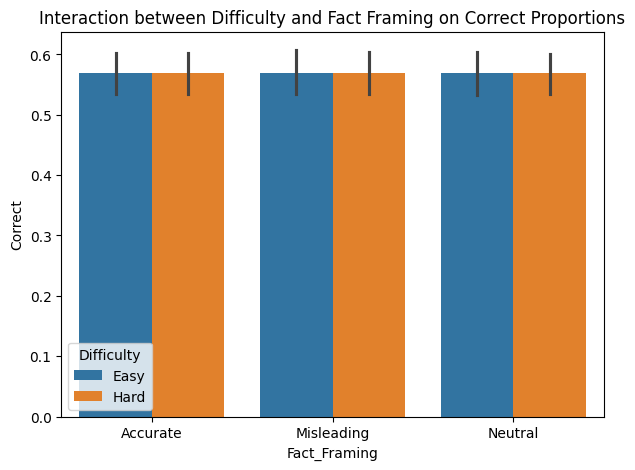

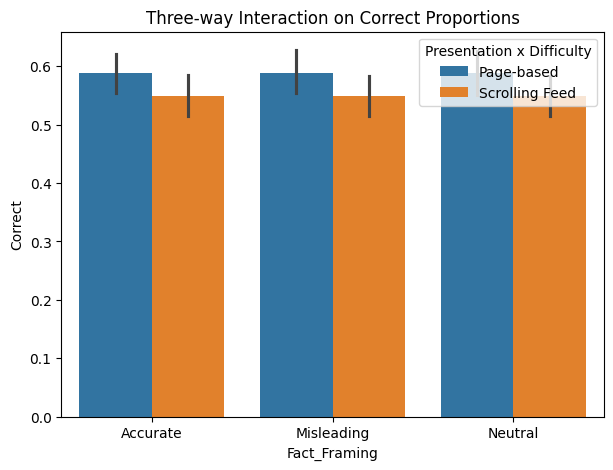

In [ ]:
# Plots for Proportions
# Main effect of Presentation on Correct Proportions
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Presentation', y='Correct')
plt.title('Main Effect of Presentation on Correct Proportions')
save_plot(fig1, 'main_effect_presentation_correct_proportions.png')
plt.show()

# Main effect of Difficulty on Correct Proportions
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Difficulty', y='Correct')
plt.title('Main Effect of Difficulty on Correct Proportions')
save_plot(fig2, 'main_effect_difficulty_correct_proportions.png')
plt.show()

# Main effect of Fact Framing on Correct Proportions
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct')
plt.title('Main Effect of Fact Framing on Correct Proportions')
save_plot(fig3, 'main_effect_fact_framing_correct_proportions.png')
plt.show()

# Interaction between Presentation and Fact Framing on Correct Proportions
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Correct Proportions')
save_plot(fig4, 'interaction_presentation_fact_framing_correct_proportions.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Correct Proportions
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Correct Proportions')
save_plot(fig5, 'interaction_difficulty_fact_framing_correct_proportions.png')
plt.show()

# Three-way interaction on Correct Proportions
fig6 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct', hue='Presentation')
plt.title('Three-way Interaction on Correct Proportions')
plt.legend(title='Presentation x Difficulty', loc='upper right')
save_plot(fig6, 'three_way_interaction_correct_proportions.png')
plt.show()


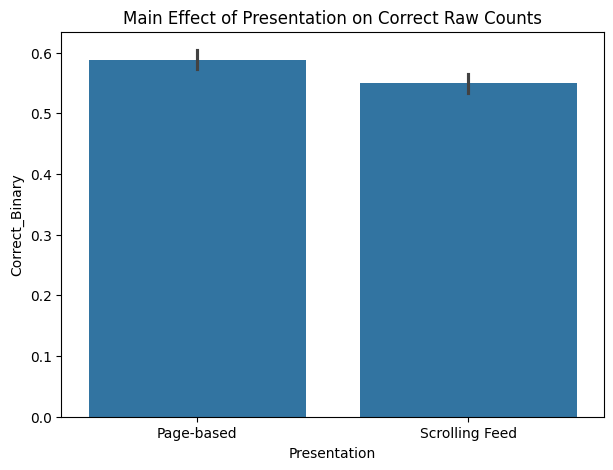

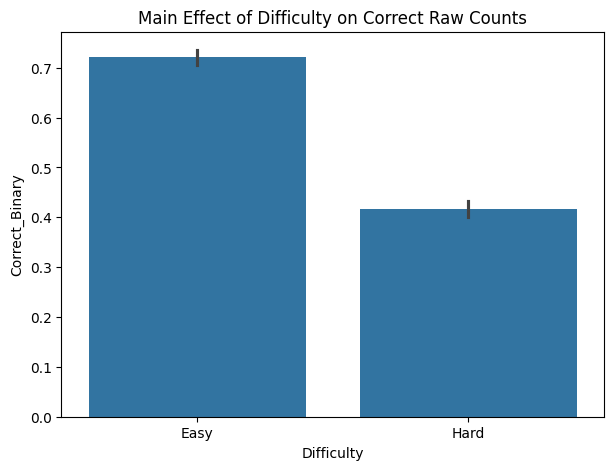

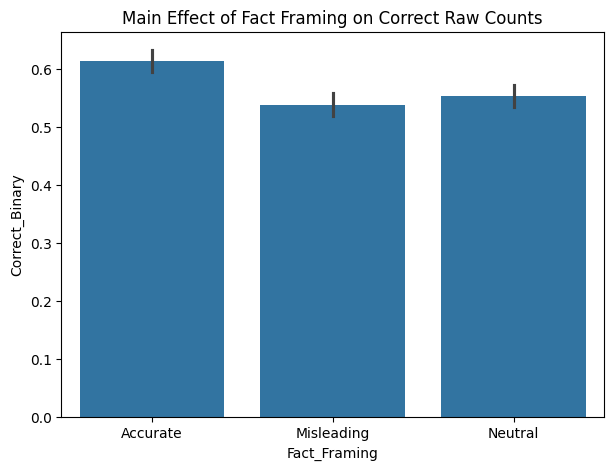

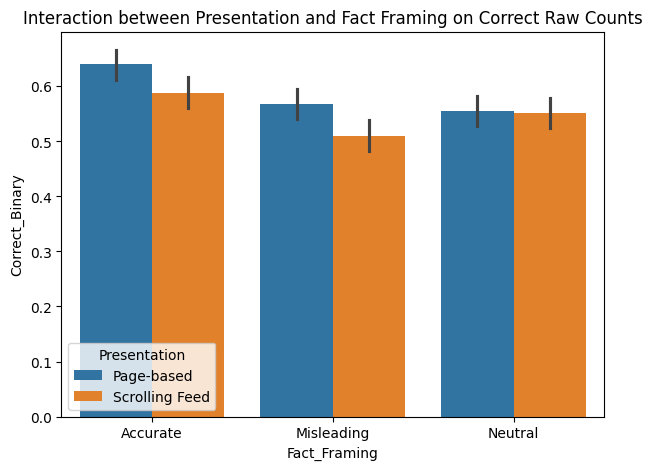

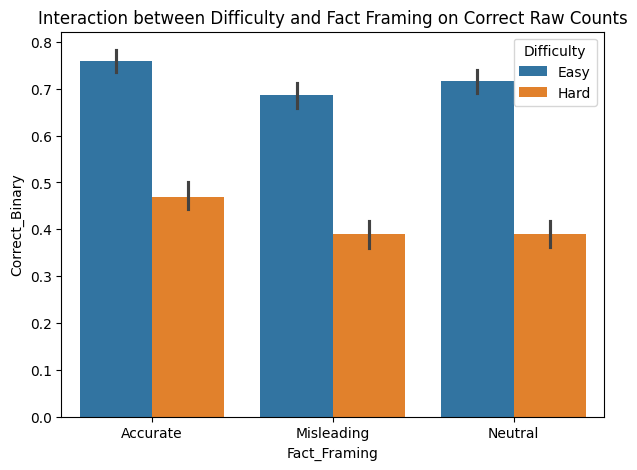

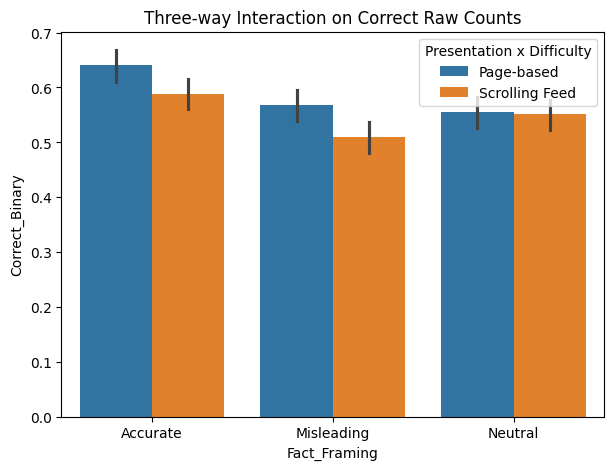

In [ ]:
# Plots for Raw Counts
# Main effect of Presentation on Correct Raw Counts
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Correct_Binary')
plt.title('Main Effect of Presentation on Correct Raw Counts')
save_plot(fig1, 'main_effect_presentation_correct_raw.png')
plt.show()

# Main effect of Difficulty on Correct Raw Counts
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Difficulty', y='Correct_Binary')
plt.title('Main Effect of Difficulty on Correct Raw Counts')
save_plot(fig2, 'main_effect_difficulty_correct_raw.png')
plt.show()

# Main effect of Fact Framing on Correct Raw Counts
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary')
plt.title('Main Effect of Fact Framing on Correct Raw Counts')
save_plot(fig3, 'main_effect_fact_framing_correct_raw.png')
plt.show()

# Interaction between Presentation and Fact Framing on Correct Raw Counts
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Correct Raw Counts')
save_plot(fig4, 'interaction_presentation_fact_framing_correct_raw.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Correct Raw Counts
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Correct Raw Counts')
save_plot(fig5, 'interaction_difficulty_fact_framing_correct_raw.png')
plt.show()

# Three-way interaction on Correct Raw Counts
fig6 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Three-way Interaction on Correct Raw Counts')
plt.legend(title='Presentation x Difficulty', loc='upper right')
save_plot(fig6, 'three_way_interaction_correct_raw.png')
plt.show()


## Optional Follow Ups

### Bootstrapping

In [ ]:
from sklearn.utils import resample

def bootstrap(data, n_iterations, sample_size, func):
    statistics = []
    for i in range(n_iterations):
        sample = resample(data, n_samples=sample_size)
        statistic = func(sample)
        statistics.append(statistic)
    return np.percentile(statistics, [2.5, 97.5])

# Bootstrap 95% CI for mean Correct proportion
bootstrap_correct = bootstrap(proportions_df['Correct'], 1000, len(proportions_df), np.mean)
print("Bootstrap 95% CI for Correct Proportion:", bootstrap_correct)

# Bootstrap 95% CI for mean Misinformed proportion
bootstrap_misinformed = bootstrap(proportions_df['Misinformed'], 1000, len(proportions_df), np.mean)
print("Bootstrap 95% CI for Misinformed Proportion:", bootstrap_misinformed)


Bootstrap 95% CI for Correct Proportion: [0.55414178 0.58248727]
Bootstrap 95% CI for Misinformed Proportion: [0.04460648 0.05111111]


Robust Regression (ANCOVA)

In [ ]:
import statsmodels.formula.api as smf

# Huber regression for Correct Proportion
model_huber_correct = smf.rlm('Correct ~ Presentation * Difficulty * Fact_Framing + Duration_sec', data=proportions_df, M=sm.robust.norms.HuberT())
results_huber_correct = model_huber_correct.fit()
print("Huber Regression Results for Correct Proportion:")
print(results_huber_correct.summary())

# Huber regression for Misinformed Proportion
model_huber_misinformed = smf.rlm('Misinformed ~ Presentation * Difficulty * Fact_Framing + Duration_sec', data=proportions_df, M=sm.robust.norms.HuberT())
results_huber_misinformed = model_huber_misinformed.fit()
print("Huber Regression Results for Misinformed Proportion:")
print(results_huber_misinformed.summary())


Huber Regression Results for Correct Proportion:
                    Robust linear Model Regression Results                    
Dep. Variable:                Correct   No. Observations:                 1200
Model:                            RLM   Df Residuals:                     1187
Method:                          IRLS   Df Model:                           12
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 16 Jun 2024                                         
Time:                        06:57:08                                         
No. Iterations:                    16                                         
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------

###  Mixed Effects Model with Robust Standard Errors

In [ ]:
# Mixed Effects Model for Correct Responses
model_correct_robust = smf.mixedlm("Correct_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                   long_df,
                                   groups=long_df["ID"],
                                   re_formula="~1")
result_correct_robust = model_correct_robust.fit(reml=True)
# Manually compute robust standard errors
robust_cov_correct = result_correct_robust.cov_params() * result_correct_robust.scale
robust_se_correct = np.sqrt(np.diag(robust_cov_correct))

print("Mixed Effects Model with Robust Standard Errors for Correct Responses:")
print(result_correct_robust.summary())
print("\nRobust Standard Errors:")
print(robust_se_correct)

# Mixed Effects Model for Misinformed Responses
model_misinformed_robust = smf.mixedlm("Misinformed_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                       long_df,
                                       groups=long_df["ID"],
                                       re_formula="~1")
result_misinformed_robust = model_misinformed_robust.fit(reml=True)
# Manually compute robust standard errors
robust_cov_misinformed = result_misinformed_robust.cov_params() * result_misinformed_robust.scale
robust_se_misinformed = np.sqrt(np.diag(robust_cov_misinformed))

print("Mixed Effects Model with Robust Standard Errors for Misinformed Responses:")
print(result_misinformed_robust.summary())
print("\nRobust Standard Errors:")
print(robust_se_misinformed)


Mixed Effects Model with Robust Standard Errors for Correct Responses:
                                         Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     Correct_Binary
No. Observations:                     7200                        Method:                                 REML          
No. Groups:                           200                         Scale:                                  0.1618        
Min. group size:                      36                          Log-Likelihood:                         -3957.3205    
Max. group size:                      36                          Converged:                              Yes           
Mean group size:                      36.0                                                                              
------------------------------------------------------------------------------------------------------------------------
   

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mixed Effects Model with Robust Standard Errors for Misinformed Responses:
                                         Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   Misinformed_Binary
No. Observations:                    7200                      Method:                               REML              
No. Groups:                          200                       Scale:                                0.0420            
Min. group size:                     36                        Log-Likelihood:                       1040.0911         
Max. group size:                     36                        Converged:                            Yes               
Mean group size:                     36.0                                                                              
-----------------------------------------------------------------------------------------------------------------------
      

# Readme

# Experiment 1A General Knowledge Analysis

This repository contains the script and instructions to preprocess, analyze, and visualize data for Experiment 1A, which investigates the impact of presentation format, difficulty, and fact framing on general knowledge recall. The analysis includes mixed effects models, ANCOVA, effect size calculations, and various plots to support the findings.

## Prerequisites

- Python 3.7 or higher
- Required Python libraries:
  - gspread
  - google-auth
  - google-auth-oauthlib
  - google-auth-httplib2
  - pandas
  - numpy
  - seaborn
  - matplotlib
  - statsmodels

## Setup

1. Clone the repository and navigate to the project directory.

2. Install the required Python libraries using pip:

    ```bash
    pip install gspread google-auth google-auth-oauthlib google-auth-httplib2 pandas numpy seaborn matplotlib statsmodels
    ```

3. Upload your `credentials.json` file to authenticate access to Google Sheets.

## Data Preprocessing

1. Load data from the specified Google Sheet.
2. Convert relevant columns to appropriate types and map categorical variables.
3. Convert data to long format and create binary response columns for `Correct_Binary` and `Misinformed_Binary`.

## Descriptive Statistics and Diagnostic Plots

1. Calculate and print descriptive statistics.
2. Generate diagnostic plots for assumption checks (normality, homoscedasticity, etc.).

## Mixed Effects Models

1. Fit mixed effects models for correct and misinformed responses.
2. Manually compute robust standard errors.

## ANCOVA Analyses

1. Perform ANCOVA on proportion data for correct and misinformed responses.
2. Conduct post-hoc analyses for significant results.

## Effect Size Calculations

1. Calculate Hedge's g for significant comparisons in both the mixed effects and ANCOVA results.
2. Calculate effect sizes for raw count data.

## Plotting Analysis Results

1. Generate and save plots for the main effects and interactions for both correct and misinformed responses (based on proportions and raw counts).

## Script Overview

The script is organized into the following sections:

1. **Setup and Data Loading:** Installs necessary libraries and loads data from Google Sheets.
2. **Data Preprocessing:** Converts data to long format and creates necessary columns.
3. **Descriptive Statistics:** Calculates and prints descriptive statistics, generates diagnostic plots.
4. **Mixed Effects Models with Robust Standard Errors:** Fits mixed effects models and computes robust standard errors.
5. **ANCOVA Analyses:** Performs ANCOVA on proportion data and conducts post-hoc analyses.
6. **Effect Size Calculations:** Calculates Hedge's g for significant comparisons.
7. **Plotting Analysis Results:** Generates and saves plots for main effects and interactions.

## Running the Script

1. Ensure you have the `credentials.json` file in your working dir
